# Kopis Internal Data EDA

## Install Necessary Libraries & Ignore Warnings

In [122]:
!pip install openpyxl
!pip install seaborn
!pip install xgboost

In [123]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, RocCurveDisplay, ConfusionMatrixDisplay

> * 한글 폰트 설정

In [183]:
import matplotlib.font_manager as fm
fm.findSystemFonts()

['/System/Library/Fonts/Supplemental/Arial Bold Italic.ttf',
 '/System/Library/Fonts/NotoNastaliq.ttc',
 '/System/Library/Fonts/Supplemental/STIXSizTwoSymBol.otf',
 '/System/Library/Fonts/Supplemental/NotoSansTagbanwa-Regular.ttf',
 '/System/Library/Fonts/Supplemental/KufiStandardGK.ttc',
 '/System/Library/Fonts/Supplemental/NotoSansMendeKikakui-Regular.ttf',
 '/System/Library/Fonts/Supplemental/DIN Condensed Bold.ttf',
 '/System/Library/Fonts/ヒラギノ角ゴシック W1.ttc',
 '/System/Library/Fonts/Supplemental/NotoSansHanunoo-Regular.ttf',
 '/Users/myungjunlee/Library/Fonts/Pretendard-Thin.otf',
 '/System/Library/Fonts/Supplemental/Khmer MN.ttc',
 '/System/Library/Fonts/Supplemental/NotoSansCuneiform-Regular.ttf',
 '/System/Library/Fonts/Supplemental/Trebuchet MS Italic.ttf',
 '/System/Library/Fonts/Supplemental/Gurmukhi Sangam MN.ttc',
 '/Users/myungjunlee/Library/Fonts/Pretendard-Medium.otf',
 '/System/Library/Fonts/Supplemental/STIXIntUpReg.otf',
 '/System/Library/Fonts/SFArmenianRounded.ttf'

In [184]:
# 폰트 경로 설정 (NanumGothic.ttc 사용)
font_path = '/System/Library/AssetsV2/com_apple_MobileAsset_Font7/bad9b4bf17cf1669dde54184ba4431c22dcad27b.asset/AssetData/NanumGothic.ttc'
fontprop = fm.FontProperties(fname=font_path)

# 폰트 등록
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = fontprop.get_name()

## Read Dataset

> * 주소별로 그룹화해서 공연장을 특정가능, 입장권 고유번호로 특정인의 예매일시와 취소일시 파악 가능?
> * 예매/취소 구분은 1, 2로 표현되고 있음 -> 0: 예매, 1: 취소로 변경

In [126]:
import pandas as pd
file_path = "(데이터) 23년(240524)/(데이터)_19년 하반기~ _23년 하반기 공모전 raw데이터_2023_01_01_10_852,741.xlsx"
df = pd.read_excel(file_path)

In [127]:
a = df.iloc[150:151].T
print(a.to_string())

                                                                                        150
전송사업자코드                                                                            SE000201
전송사업자명                                                                                 인터파크
공연시설코드                                                                             FC222284
시설특성                                                                              민간(대학로 외)
개관연도                                                                                 2004.0
주소                                                              서울특별시 강남구 테헤란로113길 7 (삼성동) 
편의시설_레스토랑 여부                                                                              N
편의시설_카페 여부                                                                                N
편의시설_편의점 여부                                                                               N
편의시설_놀이방 여부                                                                     

In [128]:
b = df[df['입장권고유번호'] == 'T0900227605'].T
print(b.to_string())

                                                                                        121                                                                        150
전송사업자코드                                                                            SE000201                                                                   SE000201
전송사업자명                                                                                 인터파크                                                                       인터파크
공연시설코드                                                                             FC222284                                                                   FC222284
시설특성                                                                              민간(대학로 외)                                                                  민간(대학로 외)
개관연도                                                                                 2004.0                                                                     2004.

In [137]:
df['예매/취소구분'] = df['예매/취소구분'].replace({1: 0, 2: 1})

In [141]:
df['예매/취소구분'].value_counts()

예매/취소구분
0    613809
1    238932
Name: count, dtype: int64

In [143]:
# '예매/취소일시'를 datetime으로 변환
df['예매/취소일시'] = pd.to_datetime(df['예매/취소일시'])

In [144]:
df_sort = df.sort_values(by = ['입장권고유번호', '예매/취소일시'])
print(df_sort.head(2).T.to_string())

                                                           683402                                           683438
전송사업자코드                                                  SE000331                                         SE000331
전송사업자명                                                         티몬                                               티몬
공연시설코드                                                   FC223469                                         FC223469
시설특성                                                       공공(기타)                                           공공(기타)
개관연도                                                       1986.0                                           1986.0
주소                                서울특별시 송파구 올림픽로 424 올림픽공원 (방이동)                   서울특별시 송파구 올림픽로 424 올림픽공원 (방이동) 
편의시설_레스토랑 여부                                                    Y                                                Y
편의시설_카페 여부                                                      Y               

In [145]:
df_sort['예매취소간격시간'] = df_sort.groupby('입장권고유번호')['예매/취소일시'].diff()
df_sort['예매취소간격시간'] = df_sort['예매취소간격시간'].fillna(pd.Timedelta(0))
df_sort['예매취소간격시간'] = df_sort['예매취소간격시간'].dt.total_seconds() / 3600
df_time_difference = df_sort[['입장권고유번호', '예매취소간격시간', '예매/취소구분']].reset_index(drop=True)
df_time_difference

,입장권고유번호,예매취소간격시간,예매/취소구분
0,0001977610XMPT,0.0,0
1,0001977610XMPT,7.1,1
2,0001977700XHPT,0.0,0
3,0002624500FFPT,0.0,0
4,0002917610BSPT,0.0,0
...,...,...,...
852736,W2399924389001,0.0,0
852737,W2399924389002,0.0,0
852738,W2399941391001,0.0,0
852739,W2399988285001,0.0,0


238932


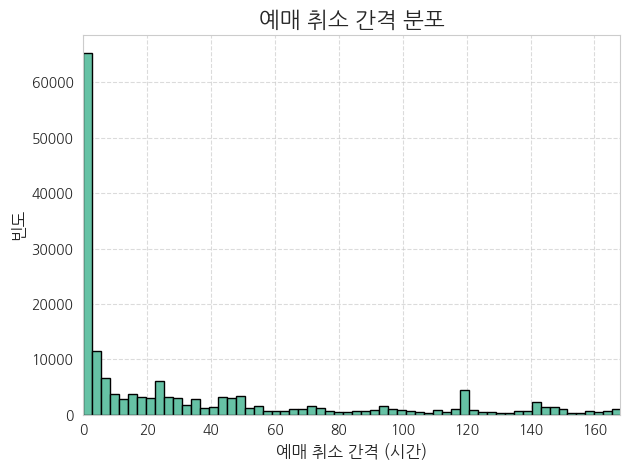


빈 평균 간격: 2.81 시간


In [146]:
# 취소 데이터만 필터링
cancel_data = df_time_difference[df_time_difference['예매/취소구분'] == 1]
print(len(cancel_data))
# 히스토그램 데이터 계산
counts, bins, _ = plt.hist(cancel_data['예매취소간격시간'], bins=1000, edgecolor='black')

# 그래프 설정
plt.title('예매 취소 간격 분포', fontsize=16)
plt.xlabel('예매 취소 간격 (시간)', fontsize=12)
plt.ylabel('빈도', fontsize=12)
plt.xlim(0, 168) # 1주일
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# 빈의 평균 간격 계산
bin_width = np.mean(np.diff(bins))
print(f"\n빈 평균 간격: {bin_width:.2f} 시간")

In [147]:
df.columns

Index(['전송사업자코드', '전송사업자명', '공연시설코드', '시설특성', '개관연도', '주소', '편의시설_레스토랑 여부',
       '편의시설_카페 여부', '편의시설_편의점 여부', '편의시설_놀이방 여부', '편의시설_수유실 여부',
       '장애인시설_주차장 여부', '장애인시설_화장실 여부', '장애인시설_경사로 여부', '장애인시설_전용엘리베이터 여부',
       '주차시설_자체 여부', '주차시설_공영 여부', '공연장코드', '좌석수', '장애인석', '무대시설_오케스트라피트 여부',
       '무대시설_연습실 여부', '무대시설_분장실 여부', '무대시설_무대넓이', '공연코드', '공연회차', '공연일시',
       '입장권고유번호', '예매/취소일시', '예매/취소구분', '예매/취소매수', '예매/취소금액', '예매/취소방식코드',
       '예매/취소방식명(관리시스템)', '예매/취소방식명(전송처)', '결제수단코드', '결제수단명(관리시스템)',
       '결제수단명(전송처)', '할인금액', '할인종류코드', '할인종류명(관리시스템)', '할인종류명(전송처)', '장당금액',
       '성별', '연령', '공연시작일자', '공연종료일자', '소요시간', '장르명', '세부장르명', '공연지역명',
       '출연진내용', '제작진내용', '기획제작사명', '원작자명', '극작가명', '수상실적', '관람연령', '아동공연 여부',
       '축제 여부', '내한공연 여부', '오픈런 여부', '판매시작일시', '판매종료일시', '좌석등급', '단독판매여부',
       '판매좌석수', '판매페이지URL'],
      dtype='object')

In [157]:
print(df['주소'].value_counts().to_string())

주소
서울특별시 송파구 올림픽로 424 올림픽공원 (방이동)                                           56720
서울특별시 송파구 올림픽로 240 (잠실동) 롯데쇼핑 ㈜ 롯데시네마 샤롯데시어터                             55990
서울특별시 중구 퇴계로 387 (흥인동) 충무아트센터                                            55638
서울특별시 용산구 이태원로 294 (한남동) 블루스퀘어                                           45401
서울특별시 서초구 남부순환로 2406 (서초동)                                               32433
부산광역시 남구 전포대로 133 (문현동)                                                  23476
서울특별시 구로구 경인로 662 (신도림동, 디큐브시티) 7층 디큐브아트센터 공연사업부                         23011
서울특별시 종로구 세종대로 175 (세종로)                                                 22358
서울특별시 강서구 마곡중앙로 136(마곡동)                                                 20599
서울특별시 종로구 대학로12길 64 (동숭동)                                                18184
서울특별시 종로구 대학로 57 (연건동) 홍익대학교대학로캠퍼스                                       17728
서울특별시 강남구 논현로163길 33 (신사동)                                               17107
서울특별시 종로구 동숭길 123 (동숭동) 링크아트센터 드림                

In [149]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 852741 entries, 0 to 852740
Data columns (total 68 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   전송사업자코드           852741 non-null  object        
 1   전송사업자명            852741 non-null  object        
 2   공연시설코드            852741 non-null  object        
 3   시설특성              852741 non-null  object        
 4   개관연도              835919 non-null  float64       
 5   주소                852741 non-null  object        
 6   편의시설_레스토랑 여부      852741 non-null  object        
 7   편의시설_카페 여부        852741 non-null  object        
 8   편의시설_편의점 여부       852741 non-null  object        
 9   편의시설_놀이방 여부       852741 non-null  object        
 10  편의시설_수유실 여부       852741 non-null  object        
 11  장애인시설_주차장 여부      852741 non-null  object        
 12  장애인시설_화장실 여부      852741 non-null  object        
 13  장애인시설_경사로 여부      852741 non-null  object        
 14  장애인시

## Cleaning Data
> * 직관적으로 관련이 없거나 결측치가 많은 경우 Drop
> * 취소율과 직접적으로 관계된 특성은 제거
> * 예매/취소 일시 -> 누가 예매를 했고, 누가 취소를 했는지 특정하기가 힘듬 / 예매일시와 취소일시를 파악할 수 있는지 확인 필요
> * 주소별로 df를 나누고(groupby) 주소별 취소율을 예측해보자

In [150]:
# 결측치 확인
df.columns[df.isnull().any()]

Index(['개관연도', '장애인석', '무대시설_무대넓이', '예매/취소방식명(전송처)', '결제수단명(전송처)',
       '할인종류명(전송처)', '소요시간', '출연진내용', '제작진내용', '기획제작사명', '원작자명', '극작가명',
       '수상실적', '좌석등급', '판매좌석수', '판매페이지URL'],
      dtype='object')

In [151]:
# '좌석등급'과 '판매좌석수'가 결측치인 행 제거
df_cleaned = df.dropna(subset=['좌석등급', '판매좌석수'])

In [152]:
# 나머지 결측치 있는 컬럼 드롭
columns_to_drop = ['개관연도', '장애인석', '무대시설_무대넓이', '예매/취소방식명(전송처)', '결제수단명(전송처)',
       '할인종류명(전송처)', '소요시간', '출연진내용', '제작진내용', '기획제작사명', '원작자명', '극작가명',
       '수상실적', '판매페이지URL', '예매/취소일시', '예매/취소매수', '예매/취소방식코드', '예매/취소금액', '예매/취소방식명(관리시스템)']

df_cleaned = df_cleaned.drop(columns=columns_to_drop)

In [153]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 827811 entries, 0 to 852740
Data columns (total 49 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   전송사업자코드           827811 non-null  object
 1   전송사업자명            827811 non-null  object
 2   공연시설코드            827811 non-null  object
 3   시설특성              827811 non-null  object
 4   주소                827811 non-null  object
 5   편의시설_레스토랑 여부      827811 non-null  object
 6   편의시설_카페 여부        827811 non-null  object
 7   편의시설_편의점 여부       827811 non-null  object
 8   편의시설_놀이방 여부       827811 non-null  object
 9   편의시설_수유실 여부       827811 non-null  object
 10  장애인시설_주차장 여부      827811 non-null  object
 11  장애인시설_화장실 여부      827811 non-null  object
 12  장애인시설_경사로 여부      827811 non-null  object
 13  장애인시설_전용엘리베이터 여부  827811 non-null  object
 14  주차시설_자체 여부        827811 non-null  object
 15  주차시설_공영 여부        827811 non-null  object
 16  공연장코드             827811 non-null  object
 

In [158]:
# 주소를 groupby 해서 주소별 데이터프레임 생성
df_address = {address: df for address, df in df_cleaned.groupby('주소')}
df_address

{'강원도 삼척시 엑스포로 45 (성남동) ':          전송사업자코드  전송사업자명    공연시설코드      시설특성                      주소  \
 419169  SE000201    인터파크  FC222577  공공(문예회관)  강원도 삼척시 엑스포로 45 (성남동)    
 419170  SE000201    인터파크  FC222577  공공(문예회관)  강원도 삼척시 엑스포로 45 (성남동)    
 419171  SE000201    인터파크  FC222577  공공(문예회관)  강원도 삼척시 엑스포로 45 (성남동)    
 419172  SE000201    인터파크  FC222577  공공(문예회관)  강원도 삼척시 엑스포로 45 (성남동)    
 419173  SE000201    인터파크  FC222577  공공(문예회관)  강원도 삼척시 엑스포로 45 (성남동)    
 ...          ...     ...       ...       ...                     ...   
 505926  SE000303  네이버N예약  FC222577  공공(문예회관)  강원도 삼척시 엑스포로 45 (성남동)    
 505927  SE000303  네이버N예약  FC222577  공공(문예회관)  강원도 삼척시 엑스포로 45 (성남동)    
 505928  SE000303  네이버N예약  FC222577  공공(문예회관)  강원도 삼척시 엑스포로 45 (성남동)    
 505929  SE000303  네이버N예약  FC222577  공공(문예회관)  강원도 삼척시 엑스포로 45 (성남동)    
 505930  SE000303  네이버N예약  FC222577  공공(문예회관)  강원도 삼척시 엑스포로 45 (성남동)    
 
        편의시설_레스토랑 여부 편의시설_카페 여부 편의시설_편의점 여부 편의시설_놀이방 여부 편의시설_수유실 여부  ...  \
 419169            N

In [160]:
list(df_address.keys())

['강원도 삼척시 엑스포로 45 (성남동) ',
 '강원도 춘천시 강원대학길 1 (효자동) ',
 '강원도 춘천시 스포츠타운길399번길 25 (삼천동) ',
 '경기도 고양시 덕양구 어울림로 33 (성사동) ',
 '경기도 고양시 일산동구 중앙로 1286 (마두동) 고양아람누리 고양아람누리',
 '경기도 고양시 일산서구 킨텍스로 217-60 (대화동) ',
 '경기도 광명시 철망산로 2(하안동) 광명문화예술교육지원센터',
 '경기도 광명시 하안로288번길 15 (하안동) 조일프라자빌딩',
 '경기도 광주시 회안대로 891 (송정동) ',
 '경기도 군포시 고산로 599 (산본동) ',
 '경기도 남양주시 별내중앙로 30(별내동) 601호',
 '경기도 부천시 송내대로 239 (상동) 4층',
 '경기도 부천시 송내대로265번길 67(상동) 7층',
 '경기도 부천시 원미구 길주로 180 (중동) 현대백화점 중동점 9층',
 '경기도 부천시 원미구 부일로 365 (중동) ',
 '경기도 성남시 분당구 성남대로 808 (야탑동) 성남아트센터',
 '경기도 성남시 수정구 수정로 205(태평동) 지하1층',
 '경기도 성남시 수정구 수정로171번길 10 ',
 '경기도 수원시 영통구 광교호수공원로 277 (원천동, 광교중흥에스클래스) ',
 '경기도 수원시 장안구 송원로 101 (조원동) ',
 '경기도 수원시 팔달구 인계로 123 (인계동) KBS수원방송센타',
 '경기도 수원시 팔달구 정조로 767-8 (팔달로3가) 조정빌딩 2층',
 '경기도 수원시 팔달구 효원로307번길 20 (인계동) 경기도문화의전당 경기도문화의전당',
 '경기도 시흥시 소래산길 11 (대야동) ',
 '경기도 안산시 단원구 광덕대로 194 (고잔동) A관 5층',
 '경기도 안산시 단원구 화랑로 312 (고잔동) 안산문화예술의전당',
 '경기도 안성시 발화대길 21 (현수동) ',
 '경기도 안양시 만안구 문예로36번길 16 (안양동) ',
 '경기도 양주시 평화로 1215(산북동) ',


In [163]:
df_address['경기도 고양시 일산동구 중앙로 1286 (마두동) 고양아람누리 고양아람누리']

,전송사업자코드,전송사업자명,공연시설코드,시설특성,주소,편의시설_레스토랑 여부,편의시설_카페 여부,편의시설_편의점 여부,편의시설_놀이방 여부,편의시설_수유실 여부,...,관람연령,아동공연 여부,축제 여부,내한공연 여부,오픈런 여부,판매시작일시,판매종료일시,좌석등급,단독판매여부,판매좌석수
587147,SE000303,네이버N예약,FC222349,공공(문예회관),경기도 고양시 일산동구 중앙로 1286 (마두동) 고양아람누리 고양아람누리,Y,Y,N,Y,N,...,만 8세 이상,N,N,N,N,2023/01/07 00:00:00,2023/01/08 00:00:00,"VIP석(132000), R석(121000), S석(110000), A석(99000)",N,1000
587148,SE000303,네이버N예약,FC222349,공공(문예회관),경기도 고양시 일산동구 중앙로 1286 (마두동) 고양아람누리 고양아람누리,Y,Y,N,Y,N,...,만 8세 이상,N,N,N,N,2023/01/07 00:00:00,2023/01/08 00:00:00,"VIP석(132000), R석(121000), S석(110000), A석(99000)",N,1000
587149,SE000303,네이버N예약,FC222349,공공(문예회관),경기도 고양시 일산동구 중앙로 1286 (마두동) 고양아람누리 고양아람누리,Y,Y,N,Y,N,...,만 8세 이상,N,N,N,N,2023/01/07 00:00:00,2023/01/08 00:00:00,"VIP석(132000), R석(121000), S석(110000), A석(99000)",N,1000
587150,SE000303,네이버N예약,FC222349,공공(문예회관),경기도 고양시 일산동구 중앙로 1286 (마두동) 고양아람누리 고양아람누리,Y,Y,N,Y,N,...,만 8세 이상,N,N,N,N,2023/01/07 00:00:00,2023/01/08 00:00:00,"VIP석(132000), R석(121000), S석(110000), A석(99000)",N,1000
587151,SE000303,네이버N예약,FC222349,공공(문예회관),경기도 고양시 일산동구 중앙로 1286 (마두동) 고양아람누리 고양아람누리,Y,Y,N,Y,N,...,만 8세 이상,N,N,N,N,2023/01/07 00:00:00,2023/01/08 00:00:00,"VIP석(132000), R석(121000), S석(110000), A석(99000)",N,1000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
741454,SE000303,네이버N예약,FC222349,공공(문예회관),경기도 고양시 일산동구 중앙로 1286 (마두동) 고양아람누리 고양아람누리,Y,Y,N,Y,N,...,만 8세 이상,N,N,N,N,2023/01/07 00:00:00,2023/01/08 00:00:00,"VIP석(132000), R석(121000), S석(110000), A석(99000)",N,1000
741455,SE000303,네이버N예약,FC222349,공공(문예회관),경기도 고양시 일산동구 중앙로 1286 (마두동) 고양아람누리 고양아람누리,Y,Y,N,Y,N,...,만 8세 이상,N,N,N,N,2023/01/07 00:00:00,2023/01/08 00:00:00,"VIP석(132000), R석(121000), S석(110000), A석(99000)",N,1000
741456,SE000303,네이버N예약,FC222349,공공(문예회관),경기도 고양시 일산동구 중앙로 1286 (마두동) 고양아람누리 고양아람누리,Y,Y,N,Y,N,...,만 8세 이상,N,N,N,N,2023/01/07 00:00:00,2023/01/08 00:00:00,"VIP석(132000), R석(121000), S석(110000), A석(99000)",N,1000
741457,SE000303,네이버N예약,FC222349,공공(문예회관),경기도 고양시 일산동구 중앙로 1286 (마두동) 고양아람누리 고양아람누리,Y,Y,N,Y,N,...,만 8세 이상,N,N,N,N,2023/01/07 00:00:00,2023/01/08 00:00:00,"VIP석(132000), R석(121000), S석(110000), A석(99000)",N,1000


## Summary Statistics for Dataset

In [164]:
df_address['경기도 고양시 일산동구 중앙로 1286 (마두동) 고양아람누리 고양아람누리'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 3735 entries, 587147 to 741458
Data columns (total 49 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   전송사업자코드           3735 non-null   object
 1   전송사업자명            3735 non-null   object
 2   공연시설코드            3735 non-null   object
 3   시설특성              3735 non-null   object
 4   주소                3735 non-null   object
 5   편의시설_레스토랑 여부      3735 non-null   object
 6   편의시설_카페 여부        3735 non-null   object
 7   편의시설_편의점 여부       3735 non-null   object
 8   편의시설_놀이방 여부       3735 non-null   object
 9   편의시설_수유실 여부       3735 non-null   object
 10  장애인시설_주차장 여부      3735 non-null   object
 11  장애인시설_화장실 여부      3735 non-null   object
 12  장애인시설_경사로 여부      3735 non-null   object
 13  장애인시설_전용엘리베이터 여부  3735 non-null   object
 14  주차시설_자체 여부        3735 non-null   object
 15  주차시설_공영 여부        3735 non-null   object
 16  공연장코드             3735 non-null   object
 17  좌석수         

In [165]:
df_address['경기도 고양시 일산동구 중앙로 1286 (마두동) 고양아람누리 고양아람누리'].describe().T

,count,mean,std,min,25%,50%,75%,max
좌석수,3735.0,1887.000000,0.000000,1887.0,1887.0,1887.0,1887.0,1887.0
공연회차,3735.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
예매/취소구분,3735.0,0.260241,0.438825,0.0,0.0,0.0,1.0,1.0
결제수단코드,3735.0,39.438822,47.298417,1.0,2.0,2.0,99.0,99.0
할인금액,3735.0,20474.431058,47075.668351,0.0,0.0,0.0,0.0,132000.0
할인종류코드,3735.0,99.000000,0.000000,99.0,99.0,99.0,99.0,99.0
장당금액,3735.0,103661.526104,50733.857914,0.0,110000.0,132000.0,132000.0,132000.0
성별,3735.0,1.067202,0.900237,0.0,0.0,1.0,2.0,2.0
연령,3735.0,1240.614726,958.625797,0.0,0.0,1972.0,1985.0,2005.0


In [166]:
df_address['경기도 고양시 일산동구 중앙로 1286 (마두동) 고양아람누리 고양아람누리'].describe(include='object').T

,count,unique,top,freq
전송사업자코드,3735,4,SE000201,2114
전송사업자명,3735,4,인터파크,2114
공연시설코드,3735,1,FC222349,3735
시설특성,3735,1,공공(문예회관),3735
주소,3735,1,경기도 고양시 일산동구 중앙로 1286 (마두동) 고양아람누리 고양아람누리,3735
편의시설_레스토랑 여부,3735,1,Y,3735
편의시설_카페 여부,3735,1,Y,3735
편의시설_편의점 여부,3735,1,N,3735
편의시설_놀이방 여부,3735,1,Y,3735
편의시설_수유실 여부,3735,1,N,3735


## Data Preprocessing

> * 관계없는 정보를 가진 특성 제거
> * Feature 엔지니어링 작업 및 높은 카디널리티 특성 제거
> * object type은 one-hot encoding

In [167]:
# object 타입의 컬럼 선택
object_columns = df_address['경기도 고양시 일산동구 중앙로 1286 (마두동) 고양아람누리 고양아람누리'].select_dtypes(include=['object']).columns.tolist()
object_columns.remove('주소')
object_columns

['전송사업자코드',
 '전송사업자명',
 '공연시설코드',
 '시설특성',
 '편의시설_레스토랑 여부',
 '편의시설_카페 여부',
 '편의시설_편의점 여부',
 '편의시설_놀이방 여부',
 '편의시설_수유실 여부',
 '장애인시설_주차장 여부',
 '장애인시설_화장실 여부',
 '장애인시설_경사로 여부',
 '장애인시설_전용엘리베이터 여부',
 '주차시설_자체 여부',
 '주차시설_공영 여부',
 '공연장코드',
 '무대시설_오케스트라피트 여부',
 '무대시설_연습실 여부',
 '무대시설_분장실 여부',
 '공연코드',
 '공연일시',
 '입장권고유번호',
 '결제수단명(관리시스템)',
 '할인종류명(관리시스템)',
 '공연시작일자',
 '공연종료일자',
 '장르명',
 '세부장르명',
 '공연지역명',
 '관람연령',
 '아동공연 여부',
 '축제 여부',
 '내한공연 여부',
 '오픈런 여부',
 '판매시작일시',
 '판매종료일시',
 '좌석등급',
 '단독판매여부',
 '판매좌석수']

In [168]:
# one-hot 인코딩 수행
df_encoded = pd.get_dummies(df_address['경기도 고양시 일산동구 중앙로 1286 (마두동) 고양아람누리 고양아람누리'], columns=object_columns, drop_first=True)

In [169]:
len(df_encoded)

3735

In [170]:
print(df_encoded.shape)
print(df_encoded.columns)

(3735, 2875)
Index(['주소', '좌석수', '공연회차', '예매/취소구분', '결제수단코드', '할인금액', '할인종류코드', '장당금액',
       '성별', '연령',
       ...
       '판매좌석수_334석', '판매좌석수_348석', '판매좌석수_364석', '판매좌석수_67석', '판매좌석수_733석',
       '판매좌석수_76석', '판매좌석수_79석', '판매좌석수_806석', '판매좌석수_829석', '판매좌석수_831석'],
      dtype='object', length=2875)


## Split the Dataset

> * 하나의 주소 예시: 고양 아람누리

In [171]:
X = df_encoded.drop(columns=['예매/취소구분', '주소'])
y = df_encoded['예매/취소구분']

In [172]:
from sklearn.model_selection import train_test_split
# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

## DT Base Model Definition

In [173]:
from sklearn.tree import DecisionTreeClassifier
# Define the base DT model
dt_base = DecisionTreeClassifier(random_state=0)

> * DT Hyperparameter Tuning

In [174]:
def tune_clf_hyperparameters(clf, param_grid, X_train, y_train, scoring='f1', n_splits=5):
    '''
    This function optimizes the hyperparameters for a classifier by searching over a specified hyperparameter grid. 
    It uses GridSearchCV and cross-validation (StratifiedKFold) to evaluate different combinations of hyperparameters. 
    The combination with the highest F1-score for class 1 (canceled bookings) is selected as the default scoring metric. 
    The function returns the classifier with the optimal hyperparameters.
    '''
    
    # Create the cross-validation object using StratifiedKFold to ensure the class distribution is the same across all the folds
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

    # Create the GridSearchCV object
    clf_grid = GridSearchCV(clf, param_grid, cv=cv, scoring=scoring, n_jobs=-1)

    # Fit the GridSearchCV object to the training data
    clf_grid.fit(X_train, y_train)

    # Get the best hyperparameters
    best_hyperparameters = clf_grid.best_params_
    
    # Return best_estimator_ attribute which gives us the best model that has been fitted to the training data
    return clf_grid.best_estimator_, best_hyperparameters

In [175]:
# Hyperparameter grid for DT
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [13, 14, 15],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3],
    'class_weight': [{0: 1, 1: w} for w in [1, 2, 3]]
}

In [176]:
# Call the function for hyperparameter tuning
best_dt, best_dt_hyperparams = tune_clf_hyperparameters(dt_base, param_grid_dt, X_train, y_train)

In [177]:
print('DT Optimal Hyperparameters: \n', best_dt_hyperparams)

DT Optimal Hyperparameters: 
 {'class_weight': {0: 1, 1: 3}, 'criterion': 'entropy', 'max_depth': 14, 'min_samples_leaf': 3, 'min_samples_split': 2}


> * DT Model Evaluation

In [178]:
def metrics_calculator(clf, X_test, y_test, model_name):
    '''
    This function calculates all desired performance metrics for a given model on test data.
    The metrics are calculated specifically for class 1.
    '''
    y_pred = clf.predict(X_test)
    result = pd.DataFrame(data=[accuracy_score(y_test, y_pred),
                                precision_score(y_test, y_pred, pos_label=1),
                                recall_score(y_test, y_pred, pos_label=1),
                                f1_score(y_test, y_pred, pos_label=1),
                                roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])],
                          index=['Accuracy','Precision (Class 1)','Recall (Class 1)','F1-score (Class 1)','AUC (Class 1)'],
                          columns = [model_name])
    
    result = (result * 100).round(2).astype(str) + '%'                            
    return result

In [179]:
def model_evaluation(clf, X_train, X_test, y_train, y_test, model_name):
    '''
    This function provides a complete report of the model's performance including classification reports, 
    confusion matrix and ROC curve.
    '''
    sns.set(font_scale=1.2)
    
    # Generate classification report for training set
    y_pred_train = clf.predict(X_train)
    print("\n\t  Classification report for training set")
    print("-"*55)
    print(classification_report(y_train, y_pred_train))

    # Generate classification report for test set
    y_pred_test = clf.predict(X_test)
    print("\n\t   Classification report for test set")
    print("-"*55)
    print(classification_report(y_test, y_pred_test))
    
    # Create figure and subplots 
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), dpi=100, gridspec_kw={'width_ratios': [2, 2, 1]})
    
    # Define a colormap
    royalblue = LinearSegmentedColormap.from_list('royalblue', [(0, (1,1,1)), (1, (0.25,0.41,0.88))])
    royalblue_r = royalblue.reversed()

    # Plot confusion matrix for test set
    ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, colorbar=False, cmap=royalblue_r, ax=ax1)
    ax1.set_title('Confusion Matrix for Test Data')                                     
    ax1.grid(False)
    
    # Plot ROC curve for test data and display AUC score 
    RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax2)
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('ROC Curve for Test Data (Positive label: 1)')
    
    # Report results for the class specified by positive label
    result = metrics_calculator(clf, X_test, y_test, model_name)
    table = ax3.table(cellText=result.values, colLabels=result.columns, rowLabels=result.index, loc='center')
    table.scale(0.6, 2)
    table.set_fontsize(12)
    ax3.axis('tight')
    ax3.axis('off')
    # Modify color 
    for key, cell in table.get_celld().items():
        if key[0] == 0:
            cell.set_color('royalblue')
    plt.tight_layout()
    plt.show()


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.62      0.74      2210
           1       0.44      0.85      0.58       778

    accuracy                           0.68      2988
   macro avg       0.68      0.73      0.66      2988
weighted avg       0.80      0.68      0.70      2988


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.59      0.70       553
           1       0.39      0.75      0.51       194

    accuracy                           0.63       747
   macro avg       0.63      0.67      0.61       747
weighted avg       0.74      0.63      0.65       747



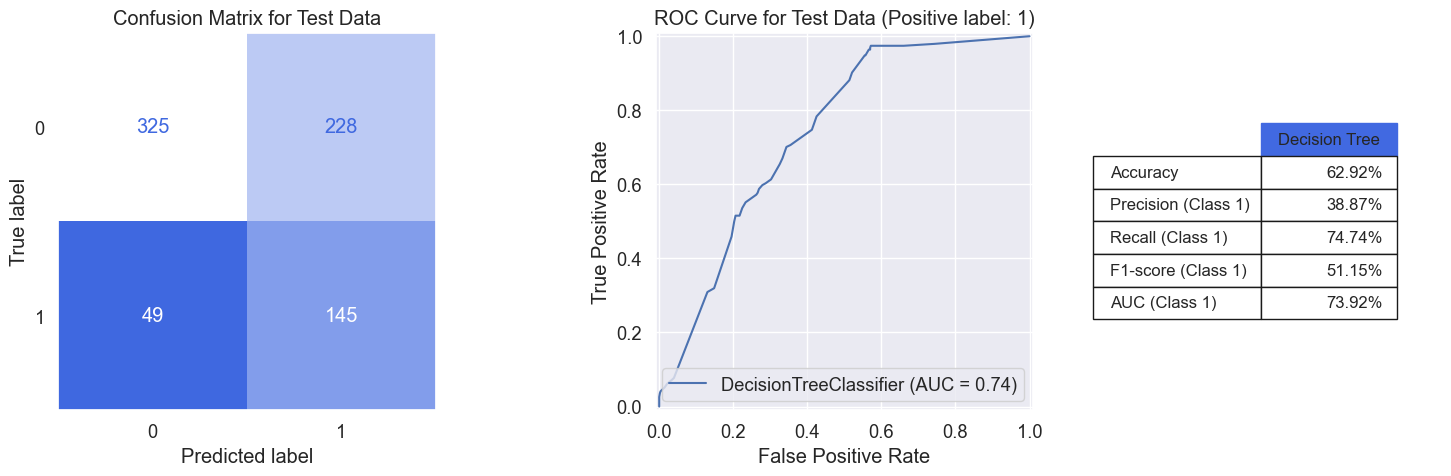

In [180]:
model_evaluation(best_dt, X_train, X_test, y_train, y_test, 'Decision Tree')

In [181]:
# Save the final performance of DT classifier
dt_result = metrics_calculator(best_dt, X_test, y_test, 'Decision Tree')
dt_result

,Decision Tree
Accuracy,62.92%
Precision (Class 1),38.87%
Recall (Class 1),74.74%
F1-score (Class 1),51.15%
AUC (Class 1),73.92%


## Desicion Tree Feature Importance

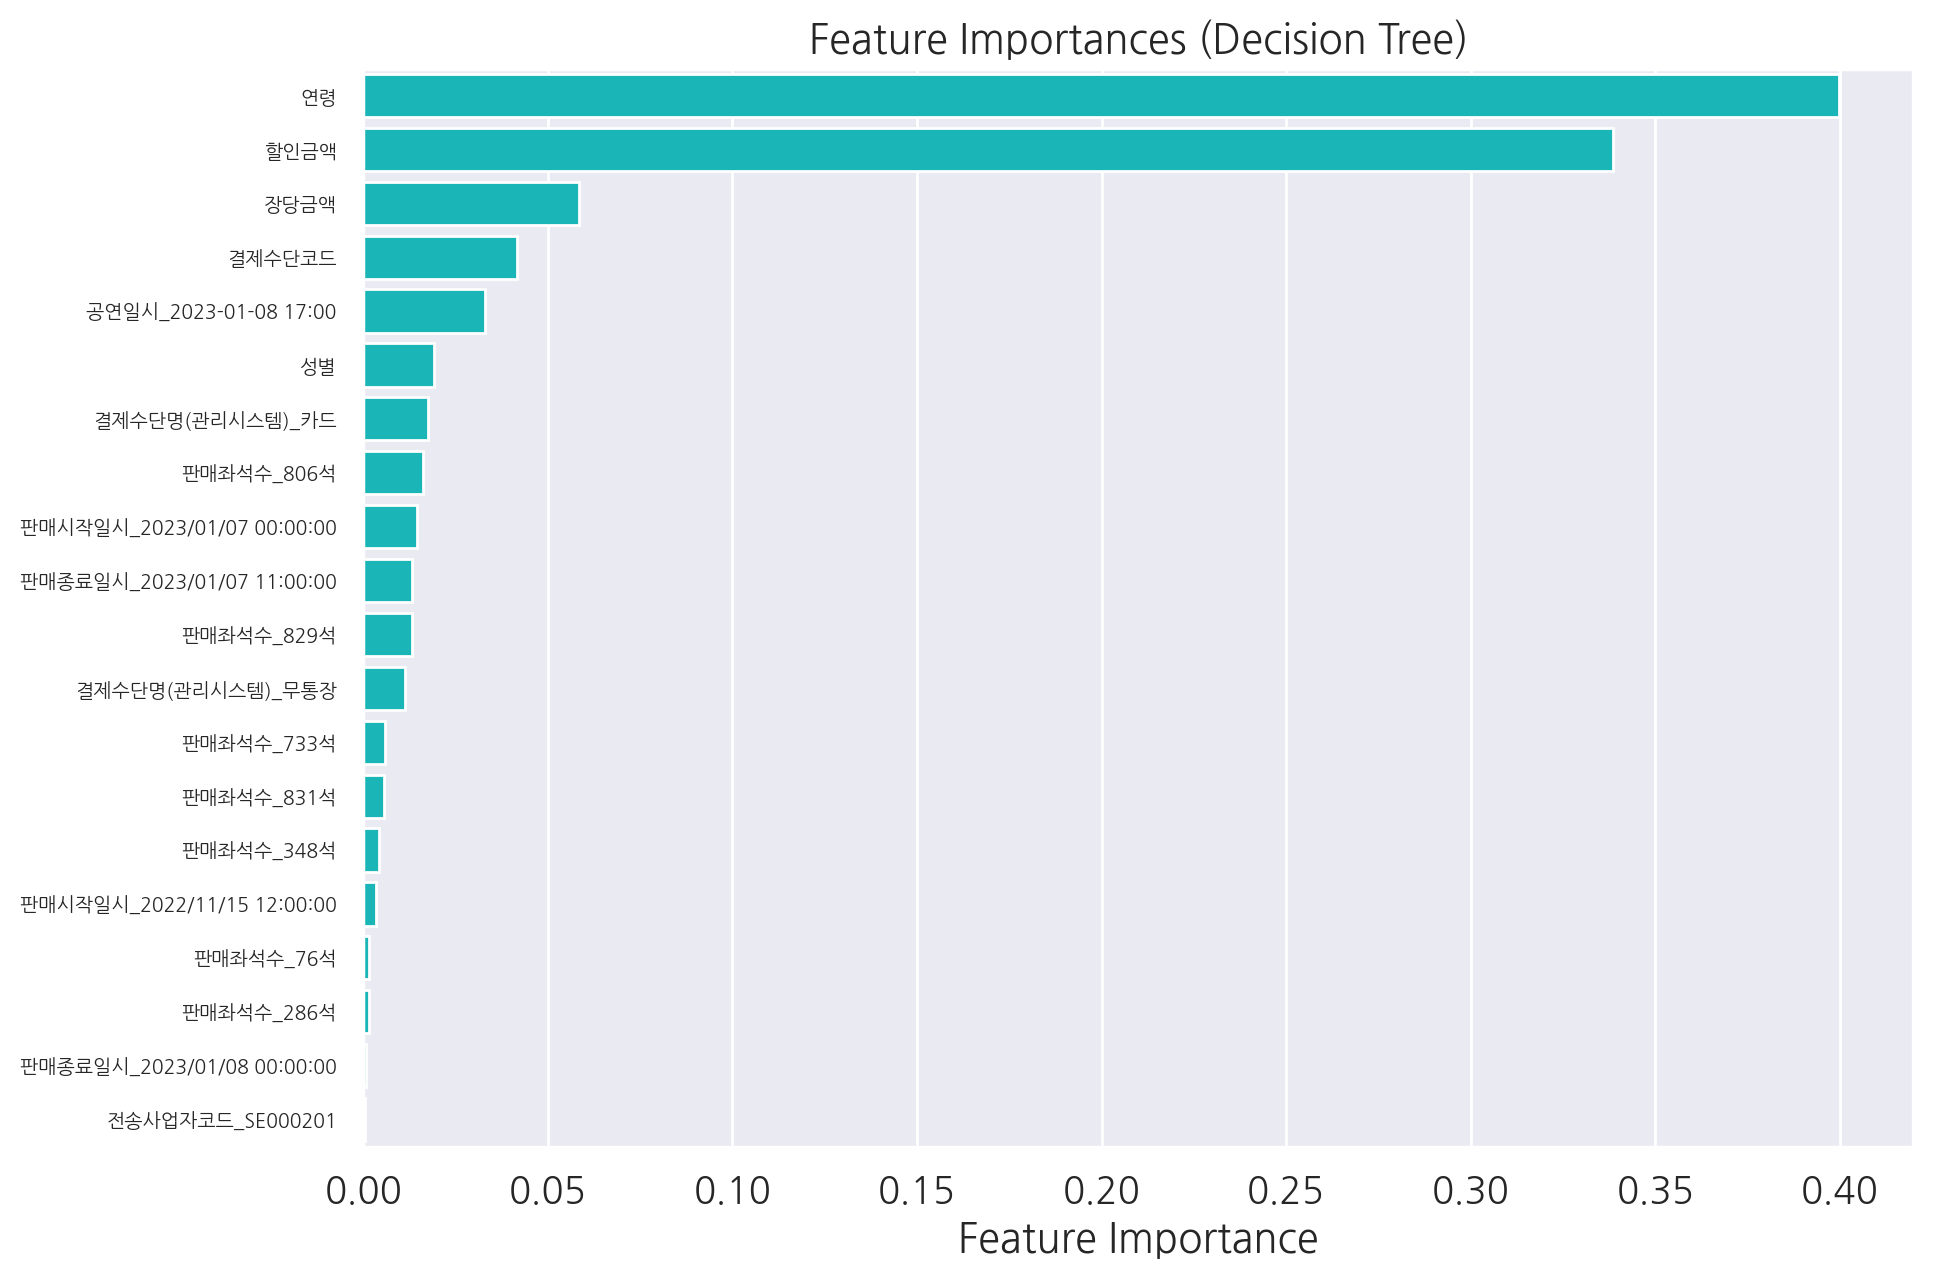

In [185]:
plt.rcParams['font.family'] = fontprop.get_name()

# 피처 중요도 추출
feature_importances_dt = best_dt.feature_importances_

# 중요도 높은 상위 20개의 피처만 선택
sorted_indices_dt = np.argsort(feature_importances_dt)[::-1]
top_n = 20
top_indices_dt = sorted_indices_dt[:top_n]

# 피처 중요도 시각화
plt.figure(figsize=(10, 7), dpi=200)
sns.barplot(x=feature_importances_dt[top_indices_dt], y=[X.columns[i] for i in top_indices_dt], color='darkturquoise')
plt.xlabel('Feature Importance')
plt.title('Feature Importances (Decision Tree)')
plt.yticks(fontsize=7)
plt.show()

## Random Forest Model Building

In [186]:
# Define the base RF model
rf_base = RandomForestClassifier(random_state=0, n_jobs=-1)

In [189]:
param_grid_rf = {
    'n_estimators': [100, 150],
    'criterion': ['entropy'],
    'max_depth': [16, 18],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3],
    'class_weight': [{0: 1, 1: w} for w in [1, 2, 3]]
}

In [190]:
# Using the tune_clf_hyperparameters function to get the best estimator
best_rf, best_rf_hyperparams = tune_clf_hyperparameters(rf_base, param_grid_rf, X_train, y_train)

In [191]:
print('RF Optimal Hyperparameters: \n', best_rf_hyperparams)

RF Optimal Hyperparameters: 
 {'class_weight': {0: 1, 1: 3}, 'criterion': 'entropy', 'max_depth': 18, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}



	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.64      0.73      2210
           1       0.41      0.70      0.51       778

    accuracy                           0.66      2988
   macro avg       0.63      0.67      0.62      2988
weighted avg       0.74      0.66      0.68      2988


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.63      0.72       553
           1       0.38      0.63      0.47       194

    accuracy                           0.63       747
   macro avg       0.60      0.63      0.59       747
weighted avg       0.71      0.63      0.65       747



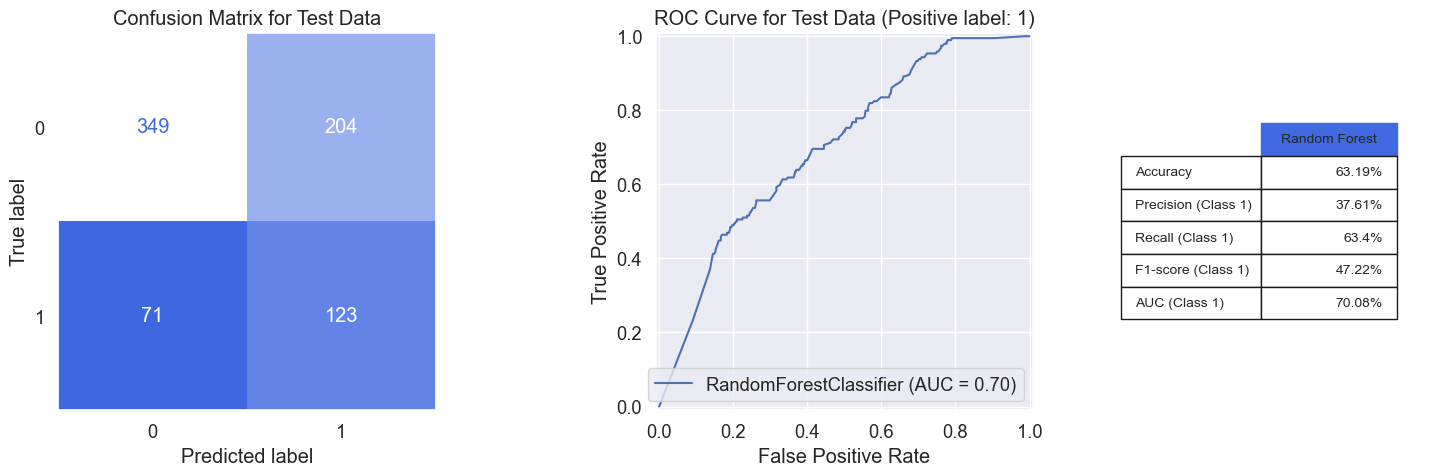

In [192]:
model_evaluation(best_rf, X_train, X_test, y_train, y_test, 'Random Forest')

In [193]:
# Save the final performance of RF classifier
rf_result = metrics_calculator(best_rf, X_test, y_test, 'Random Forest')
rf_result

,Random Forest
Accuracy,63.19%
Precision (Class 1),37.61%
Recall (Class 1),63.4%
F1-score (Class 1),47.22%
AUC (Class 1),70.08%


## Random Forest Feature Importance

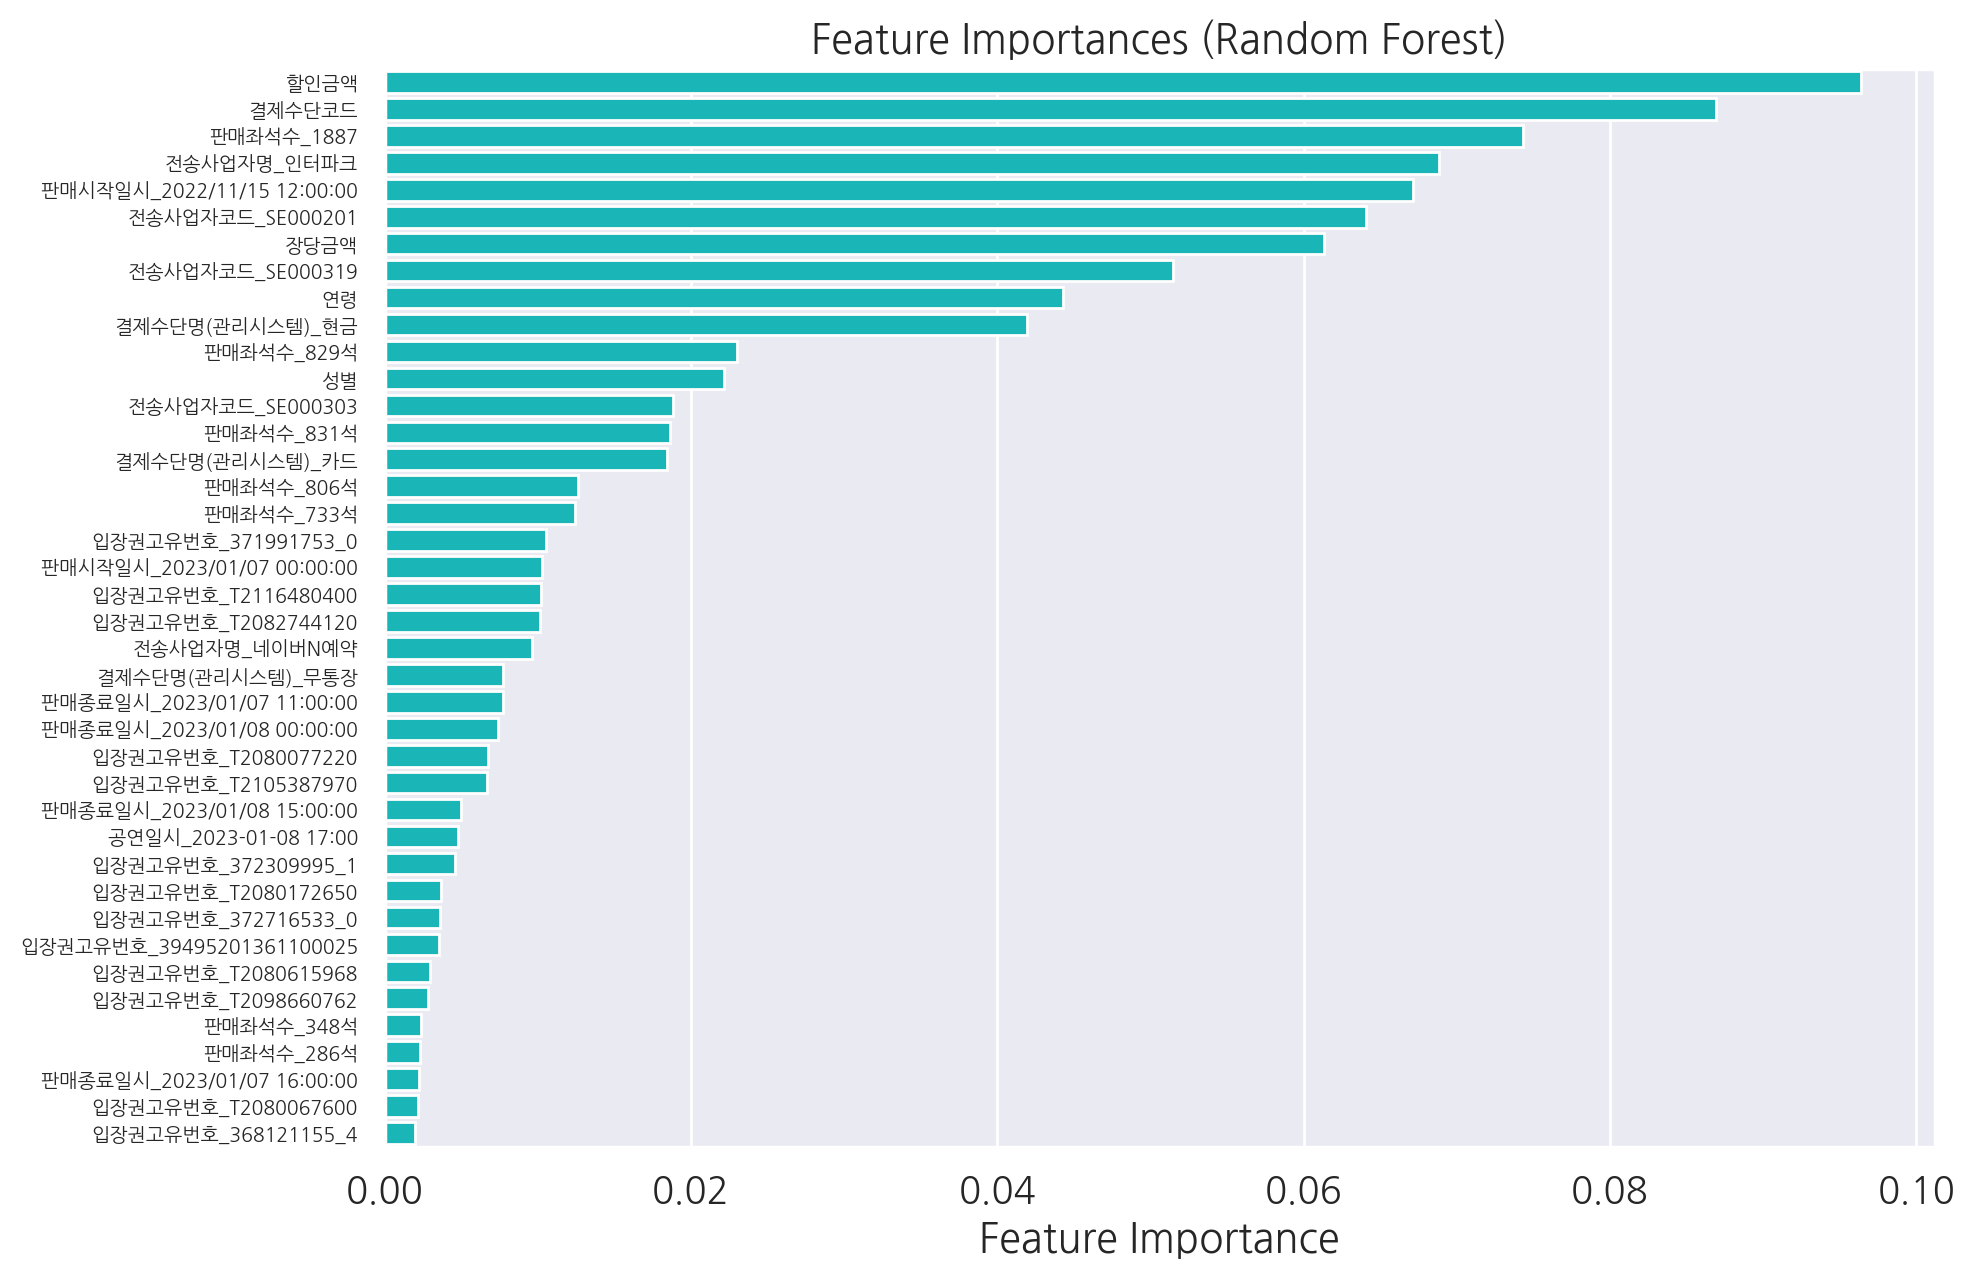

In [194]:
# 피처 중요도 추출
feature_importances = best_rf.feature_importances_

# 중요도 높은 상위 20개의 피처만 선택
sorted_indices = np.argsort(feature_importances)[::-1]
top_n = 40
top_indices = sorted_indices[:top_n]

# 폰트 등록
plt.rcParams['font.family'] = fontprop.get_name()

# 피처 중요도 시각화
plt.figure(figsize=(10, 7), dpi=200)
sns.barplot(x=feature_importances[top_indices], y=[X.columns[i] for i in top_indices], color='darkturquoise')
plt.xlabel('Feature Importance')
plt.title('Feature Importances (Random Forest)')
plt.yticks(fontsize=7)
plt.show()

## XGBoost Base Model Definition

In [195]:
# Define the model
xgb_base = xgb.XGBClassifier(eval_metric='logloss', random_state=0)

In [196]:
# Define the parameter grid
param_grid_xgb = {
    'n_estimators': [250, 350],
    'learning_rate': [0.01, 0.1],
    'max_depth': [7, 8],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.8, 0.9],
    'scale_pos_weight': [1, (y_train == 0).sum() / (y_train == 1).sum()]
}

In [197]:
# Call the function for hyperparameter tuning
best_xgb, best_xgb_hyperparams = tune_clf_hyperparameters(xgb_base, param_grid_xgb, X_train, y_train)

In [198]:
print('XGBoost Optimal Hyperparameters: \n', best_xgb_hyperparams)

XGBoost Optimal Hyperparameters: 
 {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 350, 'scale_pos_weight': 2.840616966580977, 'subsample': 0.8}



	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.66      0.78      2210
           1       0.49      0.93      0.64       778

    accuracy                           0.73      2988
   macro avg       0.73      0.79      0.71      2988
weighted avg       0.84      0.73      0.74      2988


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.62      0.74       553
           1       0.43      0.81      0.56       194

    accuracy                           0.67       747
   macro avg       0.67      0.72      0.65       747
weighted avg       0.78      0.67      0.69       747



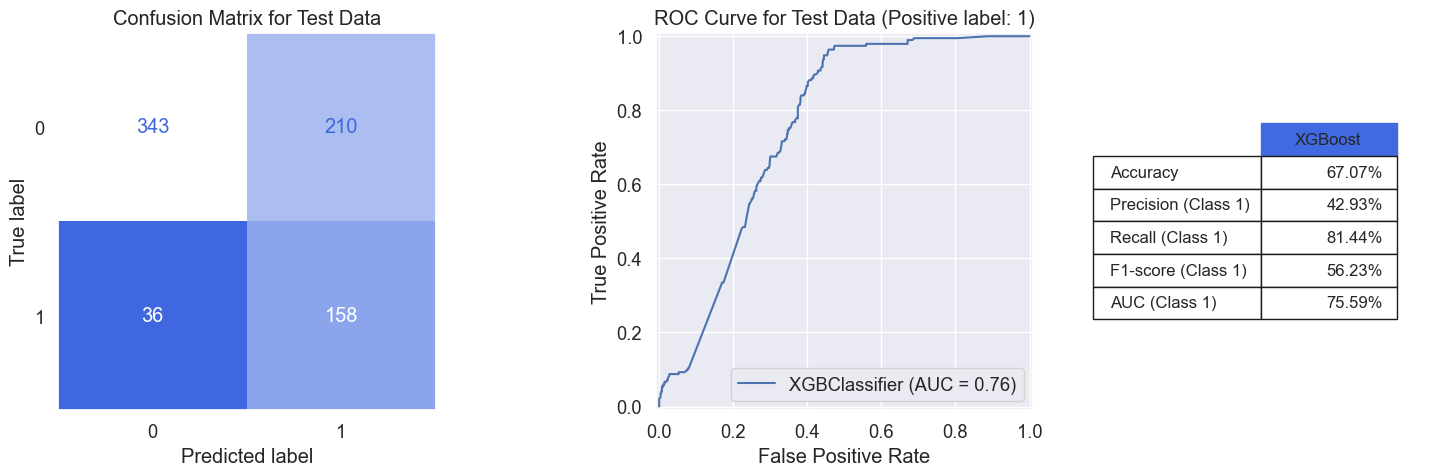

In [199]:
model_evaluation(best_xgb, X_train, X_test, y_train, y_test, 'XGBoost')

In [200]:
# Save the final performance of XGBoost classifier
xgb_result = metrics_calculator(best_xgb, X_test, y_test, 'XGBoost')
xgb_result

,XGBoost
Accuracy,67.07%
Precision (Class 1),42.93%
Recall (Class 1),81.44%
F1-score (Class 1),56.23%
AUC (Class 1),75.59%


## XGBoost Feature Importance

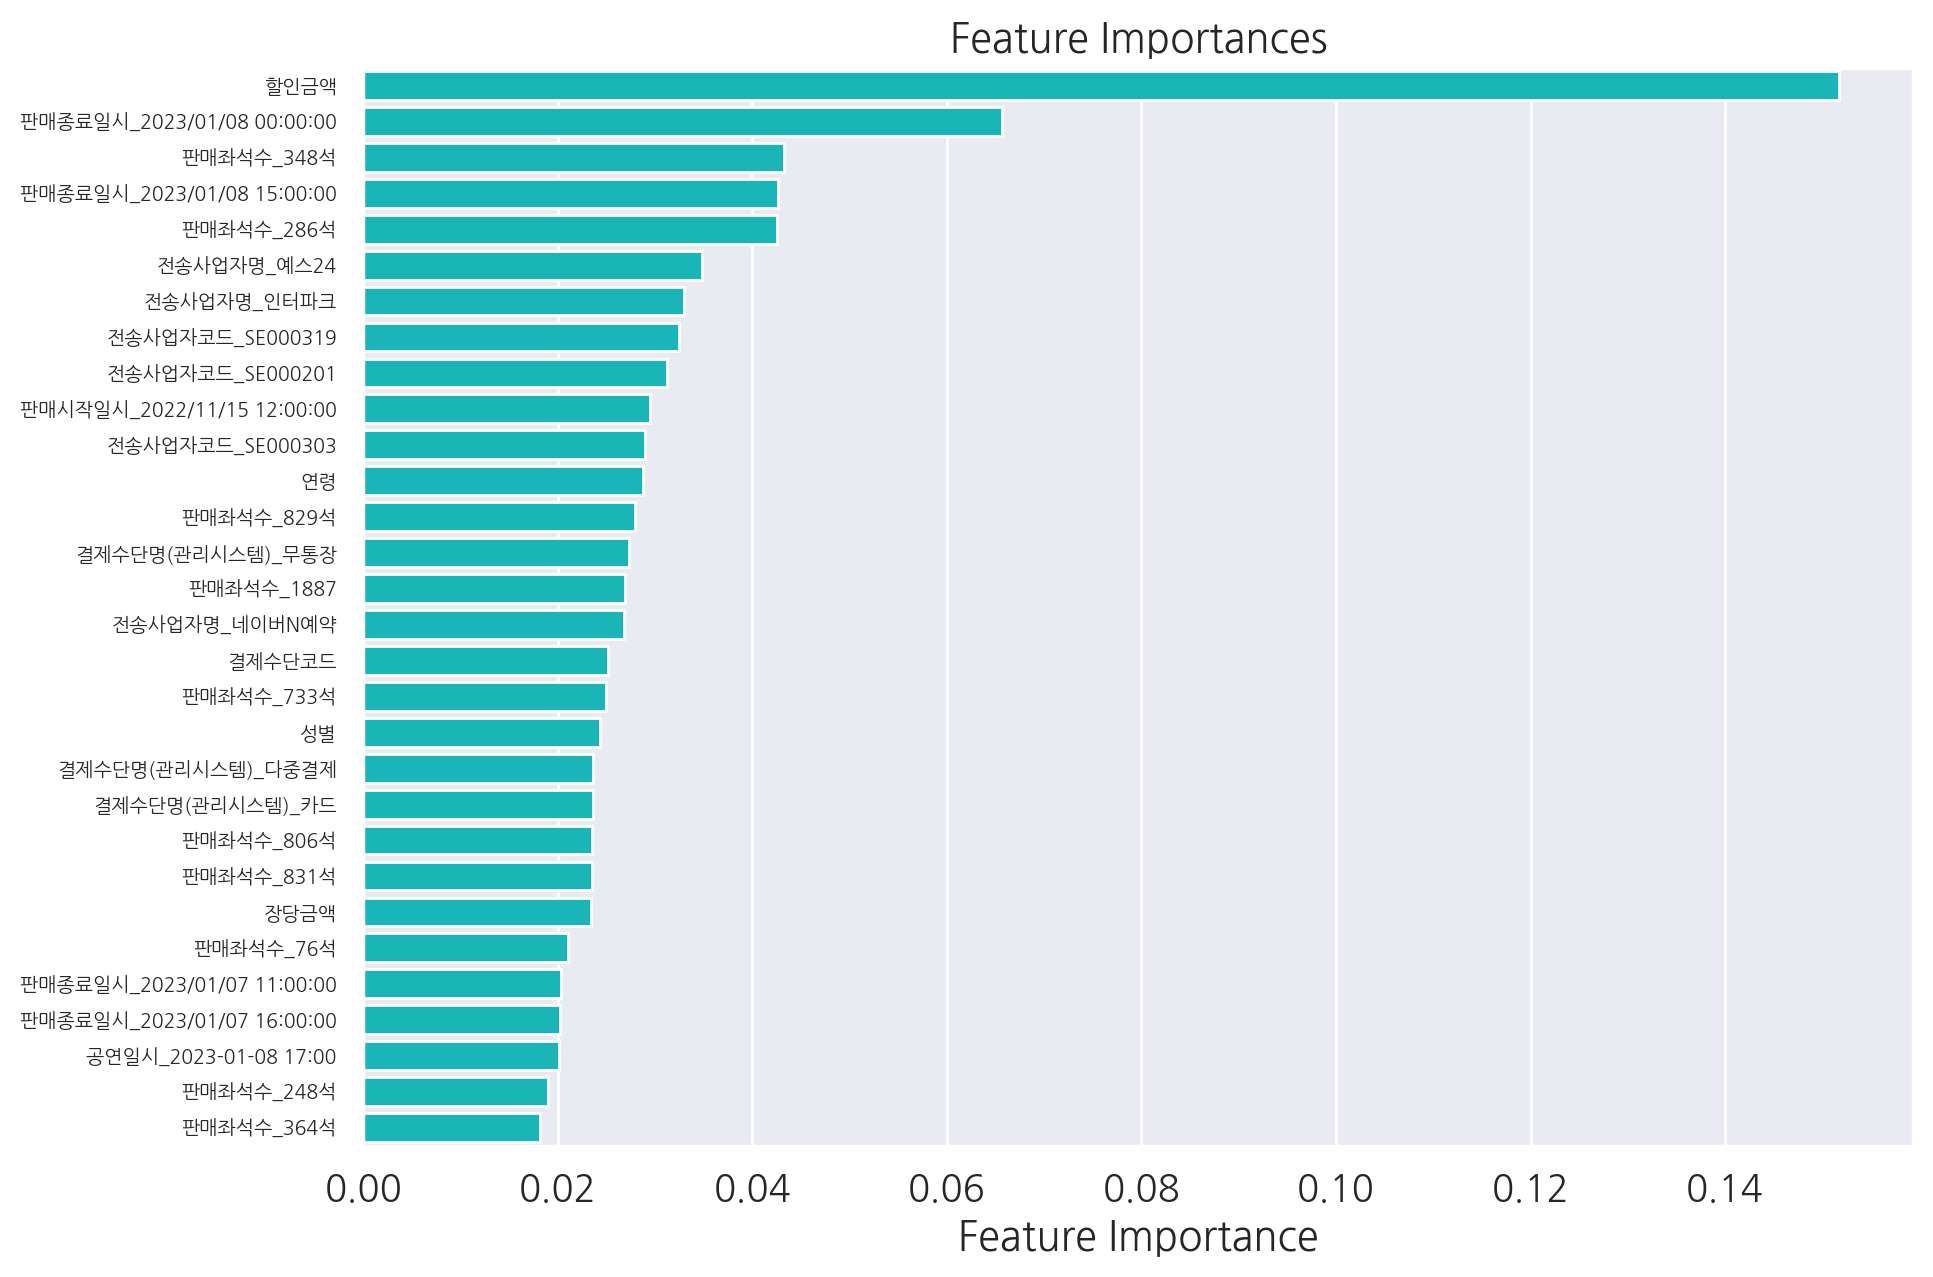

In [201]:
# Compute feature importances
feature_importances = best_xgb.feature_importances_

# Sort the feature importances in descending order and get the indices
sorted_indices = np.argsort(feature_importances)[::-1]

# 폰트 등록
plt.rcParams['font.family'] = fontprop.get_name()

# 상위 n개의 피처만 선택
top_n = 30
top_indices = sorted_indices[:top_n]

# Plot feature importances
plt.figure(figsize=(10, 7), dpi=200)
sns.barplot(x=feature_importances[top_indices], y=[X.columns[i] for i in top_indices], color='darkturquoise')
plt.xlabel('Feature Importance')
plt.title('Feature Importances')
plt.yticks(fontsize=7)
plt.show()

## Conclusion

In [202]:
# Concatenate previous classifiers perfermance results into a single dataframe
results = pd.concat([dt_result, rf_result, xgb_result], axis=1).T

# Sort the dataframe in descending order based on F1-score (class 1) values
results.sort_values(by='F1-score (Class 1)', ascending=False, inplace=True)

# Color the F1-score column
results.style.applymap(lambda x: 'background-color: royalblue', subset='F1-score (Class 1)')

,Accuracy,Precision (Class 1),Recall (Class 1),F1-score (Class 1),AUC (Class 1)
XGBoost,67.07%,42.93%,81.44%,56.23%,75.59%
Decision Tree,62.92%,38.87%,74.74%,51.15%,73.92%
Random Forest,63.19%,37.61%,63.4%,47.22%,70.08%


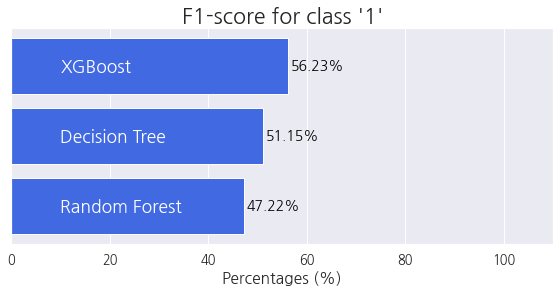

In [203]:
# Prepare values
results.sort_values(by='F1-score (Class 1)', ascending=True, inplace=True)
f1_scores = results['F1-score (Class 1)'].str.strip('%').astype(float)

# Plot the barh chart
fig, ax = plt.subplots(figsize=(10, 4), dpi=70)
ax.barh(results.index, f1_scores, color='royalblue')

# Annotate the values and indexes
for i, (value, name) in enumerate(zip(f1_scores, results.index)):
    ax.text(value+0.5, i, f"{value}%", ha='left', va='center', fontweight='bold', color='black')
    ax.text(10, i, name, ha='left', va='center', fontweight='bold', color='white', fontsize=18)

# Remove yticks
ax.set_yticks([])

# Set x-axis limit
ax.set_xlim([0,110])

# Add title and xlabel
plt.title("F1-score for class '1'", fontweight='bold', fontsize=22)
plt.xlabel('Percentages (%)', fontsize=16)
plt.show()

## What feature importance matters

In [204]:
# 피처 중요도 추출
feature_importances_rf = best_rf.feature_importances_
feature_importances_dt = best_dt.feature_importances_
feature_importances_xgb = best_xgb.feature_importances_

# 상위 N개의 피처 선택
top_n = 100
sorted_indices_rf = np.argsort(feature_importances_rf)[::-1]
top_features_rf = [X.columns[i] for i in sorted_indices_rf[:top_n]]
top_importances_rf = feature_importances_rf[sorted_indices_rf[:top_n]]

sorted_indices_dt = np.argsort(feature_importances_dt)[::-1]
top_features_dt = [X.columns[i] for i in sorted_indices_dt[:top_n]]
top_importances_dt = feature_importances_dt[sorted_indices_dt[:top_n]]

sorted_indices_xgb = np.argsort(feature_importances_xgb)[::-1]
top_features_xgb = [X.columns[i] for i in sorted_indices_xgb[:top_n]]
top_importances_xgb = feature_importances_xgb[sorted_indices_xgb[:top_n]]

# 결과 데이터프레임 생성
def create_top_features_df(features, importances, model_name):
    return pd.DataFrame({
        'Feature': features,
        f'Importance_{model_name}': importances
    })

rf_top_df = create_top_features_df(top_features_rf, top_importances_rf, 'RF')
dt_top_df = create_top_features_df(top_features_dt, top_importances_dt, 'DT')
xgb_top_df = create_top_features_df(top_features_xgb, top_importances_xgb, 'XGB')

# 데이터프레임 병합
combined_df = pd.merge(rf_top_df, dt_top_df, on='Feature', how='outer')
combined_df = pd.merge(combined_df, xgb_top_df, on='Feature', how='outer')

# NaN 값 0으로 대체 (모델에 없는 피처의 중요도는 0으로 간주)
combined_df.fillna(0, inplace=True)

# 정렬 (랜덤 포레스트 중요도를 기준으로 정렬, 필요에 따라 변경 가능)
combined_df = combined_df.sort_values(by='Importance_RF', ascending=False)
combined_df

,Feature,Importance_RF,Importance_DT,Importance_XGB
178,할인금액,0.096368,0.338550,0.151756
4,결제수단코드,0.086892,0.041601,0.025197
165,판매좌석수_1887,0.074315,0.000000,0.026893
155,전송사업자명_인터파크,0.068854,0.000000,0.032980
159,판매시작일시_2022/11/15 12:00:00,0.067122,0.003443,0.029438
...,...,...,...,...
57,입장권고유번호_364805993_1,0.000000,0.000000,0.000000
88,입장권고유번호_365551997_2,0.000000,0.000000,0.000000
87,입장권고유번호_365551997_1,0.000000,0.000000,0.000000
86,입장권고유번호_365551997_0,0.000000,0.000000,0.000000


In [205]:
# 중요도 평균 계산
combined_df['Mean_Importance'] = combined_df[['Importance_RF', 'Importance_DT', 'Importance_XGB']].mean(axis=1)

# 평균 중요도로 정렬
combined_df = combined_df.sort_values(by='Mean_Importance', ascending=False)

In [206]:
graph_df = combined_df.head(20)

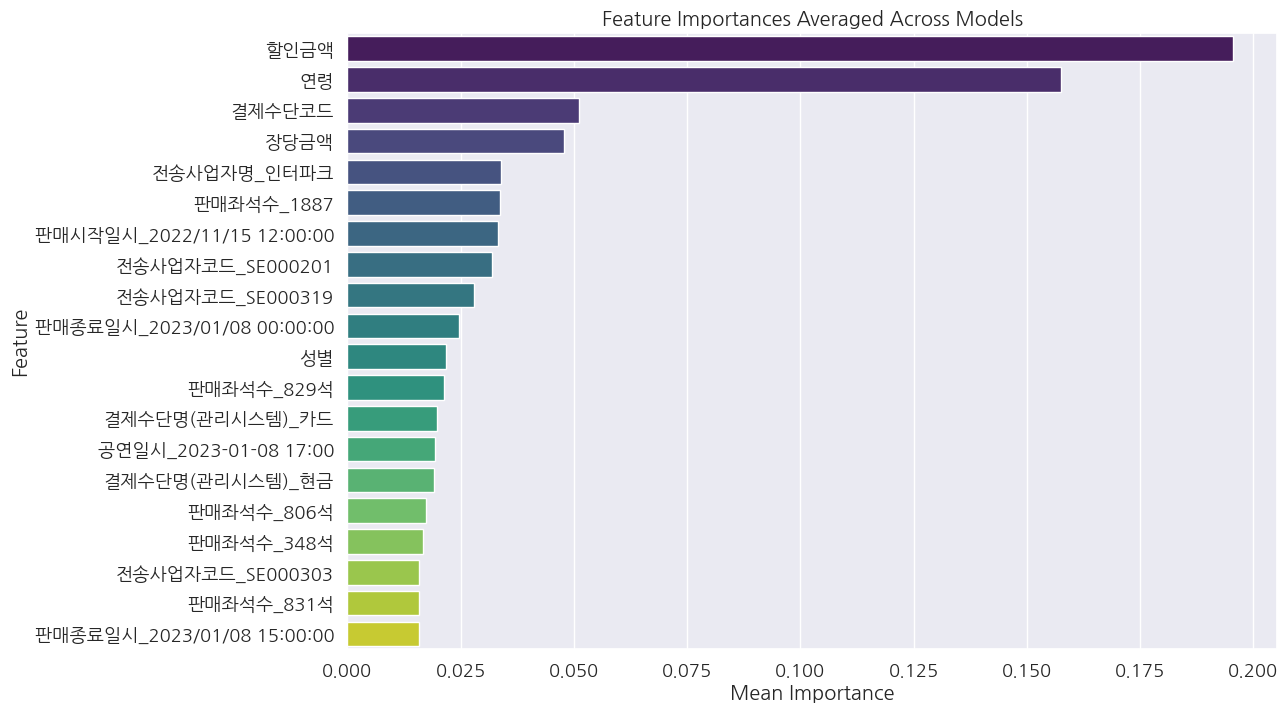

In [207]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Mean_Importance', y='Feature', data=graph_df, palette='viridis')

# 그래프 설정
plt.xlabel('Mean Importance')
plt.ylabel('Feature')
plt.title('Feature Importances Averaged Across Models')
plt.show()